In [ ]:
%cd D:\\gejun\\Documents\\Git\\YuEbaoPrediction\\ARIMA_prediction
# %cd D:\\graduation\\YuEbaoPrediction\\ARIMA_prediction
# %cd //Users//utopia//Local File//Code//MyGit//YuEbaoPrediction//ARIMA_prediction
# 使用ARIMA 预测
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import sys
from statsmodels.tsa.arima_model import ARMA

def mape(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true))
    



# 差分操作,d代表差分序列，比如[1,1,1]可以代表3阶差分。  [12,1]可以代表第一次差分偏移量是12，第二次差分偏移量是1
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list #这个序列在恢复过程中需要用到
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print (last_data_shift_list)
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=30)
    rolstd = pd.rolling_std(timeseries, window=30)

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def proper_model(ts_log_diff, maxLag):
    best_p = 0
    best_q = 0
    best_bic = sys.maxsize
    best_model=None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(ts_log_diff, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1)
            except:
                continue
            bic = results_ARMA.bic
            print (bic, best_bic)
            if bic < best_bic:
                best_p = p
                best_q = q
                best_bic = bic
                best_model = results_ARMA
    print(best_p,best_q,best_model)

df = pd.read_csv('../file/user_balance_table_all.csv', index_col='user_id', names=['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4'
], parse_dates=[1])

df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')

labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    print(label)
    df[label] = pd.to_numeric(df[label], errors='coerce')

df = df.groupby('report_date').sum()
total_redeem_original = df['total_redeem_amt']
total_redeem_original

# ts = ts['2014-04-01':'2014-06-30']

# print('原数据ADF')
# test_stationarity(ts)

total_redeem_original.plot()
plt.title('Total Redeem')
plt.show()

#一阶差分
diff_1 = diff_ts(total_redeem_original, [1])
diff_1.plot()
# plt.title('Total purchase first difference')
plt.title('Total redeem first difference')
plt.show()

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plot_acf(total_redeem_original, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(total_redeem_original)), linestyle='--', color='gray')
plot_pacf(total_redeem_original, ax=plt.gca(), lags=60)
plt.show()

diff_1 = diff_ts(total_redeem_original, [1])

print('一阶差分数据ADF')
test_stationarity(diff_1)

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plot_acf(diff_1, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_1)),linestyle='--',color='gray')
plot_pacf(diff_1, ax=plt.gca(), lags=60)
plt.show()

rol_mean = total_redeem_original.rolling(window=7).mean()
rol_mean.dropna(inplace=True)

rol_mean.plot()
plt.title('Rolling Mean')
plt.show()

ts_diff_1 = diff_ts(rol_mean, [1])

ts_diff_1.plot()
plt.title('First Difference')
plt.show()

print('移动平均并差分后ADF')
test_stationarity(ts_diff_1)

plt.figure()
plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_acf(ts_diff_1, ax=plt.gca(), lags=60)
plt.show()

plt.axhline(y=-1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff_1)),linestyle='--',color='gray')
plot_pacf(ts_diff_1, ax=plt.gca(), lags=60)
plt.show()

# proper_model(ts_diff_1, 10)

model = ARMA(ts_diff_1, order=(1, 8))
result_arma = model.fit(disp=-1, method='css')

predict_ts = result_arma.predict()

predict_ts.plot(label='predicted')
ts_diff_1.plot(label='original')
plt.legend(loc='best')
plt.show()

recovery_diff_1 = predict_diff_recover(predict_ts, [1])
recovery_diff_1.plot()
plt.show()

rol_sum = total_redeem_original.rolling(window=6).sum()
total_redeem_prediction = recovery_diff_1 * 7 - rol_sum.shift(1)

total_redeem_prediction.plot(label='predicted')
total_redeem_original.plot(label='original')

plt.legend(loc='best')
plt.show()

total_redeem_residual = total_redeem_original - total_redeem_prediction
total_redeem_residual_values = total_redeem_residual.values[8:]
df = df[8:]
df['total_redeem_amt'] = total_redeem_residual_values
df.to_csv('../file/hybrid_total_redeem.csv')


## 残差检测平稳性 判断是否是噪声
[判断是否是白噪声](https://machinelearningmastery.com/white-noise-time-series-python/)

D:\Software\Anaconda2\envs\conda36\lib\site-packages\ipykernel_launcher.py:54: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
D:\Software\Anaconda2\envs\conda36\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).std()


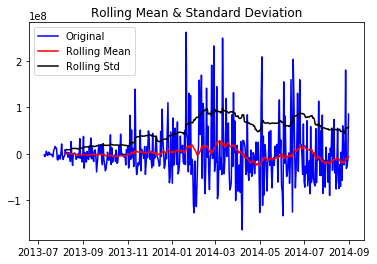

Results of Dickey-Fuller Test:
Test Statistic                 -20.302773
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    418.000000
Critical Value (1%)             -3.446091
Critical Value (5%)             -2.868479
Critical Value (10%)            -2.570466
dtype: float64


In [7]:
# 残差检测平稳性
sub_total_redeem_residual = total_redeem_residual[8:]
test_stationarity(sub_total_redeem_residual)

# 判断残差是否是噪声

In [8]:
sub_total_redeem_residual.describe()

count    4.190000e+02
mean    -3.537309e+05
std      5.737895e+07
min     -1.647455e+08
25%     -2.610457e+07
50%     -7.265322e+06
75%      1.624048e+07
max      2.623413e+08
dtype: float64

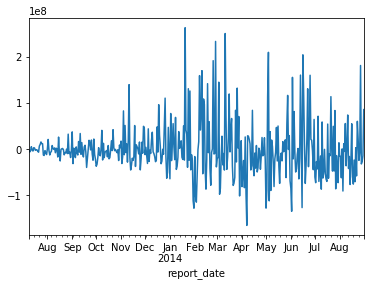

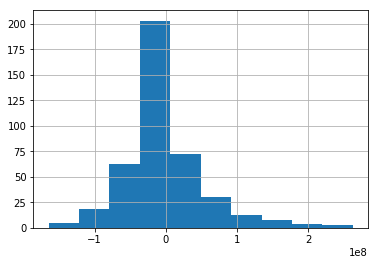

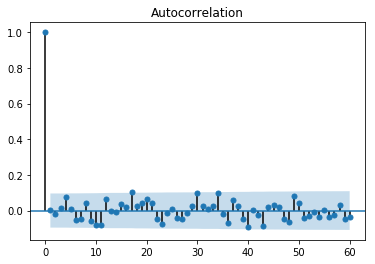

In [9]:
sub_total_redeem_residual.plot()
plt.show()

# 直方图 是否正态分布
sub_total_redeem_residual.hist()
plt.show()

# autocorrelation
plot_acf(sub_total_redeem_residual, ax=plt.gca(), lags=60)
plt.show()

In [10]:
# LBQ 检验
from statsmodels.stats import diagnostic
diagnostic.acorr_ljungbox(sub_total_redeem_residual, lags=None, boxpierce=True)

(array([  1.50207092e-03,   1.87026418e-01,   2.56015064e-01,
          2.55077118e+00,   2.58702791e+00,   3.88800679e+00,
          4.81859996e+00,   5.67223961e+00,   7.06362476e+00,
          9.88822049e+00,   1.28410669e+01,   1.47888600e+01,
          1.47895776e+01,   1.48293189e+01,   1.53442220e+01,
          1.55515439e+01,   2.01634663e+01,   2.04720740e+01,
          2.12534457e+01,   2.30164925e+01,   2.37798208e+01,
          2.47764955e+01,   2.74006219e+01,   2.74582081e+01,
          2.75042004e+01,   2.82896617e+01,   2.92742592e+01,
          2.93973611e+01,   2.97105460e+01,   3.39026773e+01,
          3.42262291e+01,   3.42783374e+01,   3.45695060e+01,
          3.91950168e+01,   3.94117681e+01,   4.15811528e+01,
          4.30821063e+01,   4.33887801e+01,   4.45342189e+01,
          4.86985017e+01]),
 array([ 0.96908448,  0.91072599,  0.96807682,  0.63556808,  0.76333522,
         0.69182903,  0.68208921,  0.68389165,  0.63049513,  0.4503543 ,
         0.30384006,

# 把 mean 加上去，然后看残差的均值是不是 0，误差是不是比原来低

In [15]:
mean = -3.537309e+05
mean_total_redeem_prediction = total_redeem_prediction[8:] + mean


2013-07-09    353730.9
2013-07-10    353730.9
2013-07-11    353730.9
2013-07-12    353730.9
2013-07-13    353730.9
2013-07-14    353730.9
2013-07-15    353730.9
2013-07-16    353730.9
2013-07-17    353730.9
2013-07-18    353730.9
2013-07-19    353730.9
2013-07-20    353730.9
2013-07-21    353730.9
2013-07-22    353730.9
2013-07-23    353730.9
2013-07-24    353730.9
2013-07-25    353730.9
2013-07-26    353730.9
2013-07-27    353730.9
2013-07-28    353730.9
2013-07-29    353730.9
2013-07-30    353730.9
2013-07-31    353730.9
2013-08-01    353730.9
2013-08-02    353730.9
2013-08-03    353730.9
2013-08-04    353730.9
2013-08-05    353730.9
2013-08-06    353730.9
2013-08-07    353730.9
                ...   
2014-08-02    353730.9
2014-08-03    353730.9
2014-08-04    353730.9
2014-08-05    353730.9
2014-08-06    353730.9
2014-08-07    353730.9
2014-08-08    353730.9
2014-08-09    353730.9
2014-08-10    353730.9
2014-08-11    353730.9
2014-08-12    353730.9
2014-08-13    353730.9
2014-08-14 

In [16]:
# 残差均值是否为 0
mean_total_redeem_residual = total_redeem_original[8:] - mean_total_redeem_prediction

mean_total_redeem_residual.describe()

count    4.190000e+02
mean    -1.738171e+08
std      1.347545e+08
min     -5.323194e+08
25%     -2.856443e+08
50%     -1.492145e+08
75%     -5.185708e+07
max      8.204034e+07
dtype: float64

In [21]:
#之前误差

arima_mape = mape(total_redeem_prediction[8:].values, total_redeem_original[8:].values)
print('ARIMA mape', arima_mape)

mean_mape = mape(mean_total_redeem_prediction.values, total_redeem_original[8:].values)

print('Add mean mape', mean_mape)

ARIMA mape 1.01964831394
Add mean mape 1.02101942059


In [24]:
test = total_redeem_original[8:] - total_redeem_prediction[8:]
total_redeem_original[8:]

report_date
2013-07-09   -2.425217e+06
2013-07-10   -6.116809e+06
2013-07-11   -3.750296e+06
2013-07-12    5.341113e+06
2013-07-13   -1.681693e+06
2013-07-14   -4.050886e+06
2013-07-15    3.203926e+06
2013-07-16    2.390717e+06
2013-07-17   -2.519469e+06
2013-07-18   -1.213386e+06
2013-07-19   -1.452462e+06
2013-07-20   -4.453082e+06
2013-07-21   -6.584680e+06
2013-07-22    6.663048e+06
2013-07-23    1.015699e+07
2013-07-24    1.555312e+07
2013-07-25    1.180167e+07
2013-07-26    1.180057e+07
2013-07-27   -1.279446e+07
2013-07-28   -1.367381e+07
2013-07-29   -3.200178e+06
2013-07-30   -7.919732e+06
2013-07-31   -1.163538e+07
2013-08-01    5.375366e+05
2013-08-02    2.099709e+07
2013-08-03   -3.156008e+06
2013-08-04   -1.256961e+07
2013-08-05   -6.930291e+06
2013-08-06   -4.898640e+06
2013-08-07    7.842991e+06
                  ...     
2014-08-02   -1.561690e+07
2014-08-03   -6.184168e+07
2014-08-04    5.443541e+05
2014-08-05   -9.044430e+07
2014-08-06    1.172288e+07
2014-08-07   -4.

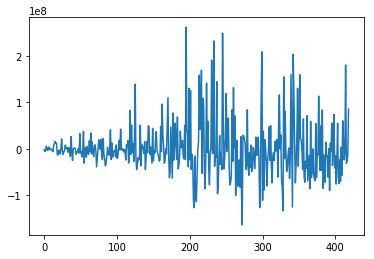

[[ -2.42521654e+06]
 [ -6.11680901e+06]
 [ -3.75029586e+06]
 [  5.34111286e+06]
 [ -1.68169296e+06]
 [ -4.05088632e+06]
 [  3.20392627e+06]
 [  2.39071721e+06]
 [ -2.51946899e+06]
 [ -1.21338621e+06]
 [ -1.45246158e+06]
 [ -4.45308185e+06]
 [ -6.58468006e+06]
 [  6.66304781e+06]
 [  1.01569950e+07]
 [  1.55531171e+07]
 [  1.18016661e+07]
 [  1.18005707e+07]
 [ -1.27944638e+07]
 [ -1.36738128e+07]
 [ -3.20017810e+06]
 [ -7.91973165e+06]
 [ -1.16353841e+07]
 [  5.37536562e+05]
 [  2.09970939e+07]
 [ -3.15600849e+06]
 [ -1.25696088e+07]
 [ -6.93029054e+06]
 [ -4.89864045e+06]
 [  7.84299121e+06]
 [  1.42621705e+06]
 [ -4.88044480e+05]
 [  2.68606503e+06]
 [ -7.74290879e+06]
 [  2.05010070e+06]
 [  1.04513246e+05]
 [ -1.69535710e+07]
 [  2.60491064e+07]
 [ -7.30460360e+06]
 [ -2.54697066e+07]
 [ -5.11837534e+05]
 [  8.77585225e+05]
 [  1.44133908e+06]
 [ -9.32552659e+05]
 [ -1.22720863e+07]
 [ -7.26532244e+06]
 [ -7.69692113e+06]
 [  4.18390282e+04]
 [ -9.57178080e+06]
 [  3.24239686e+07]


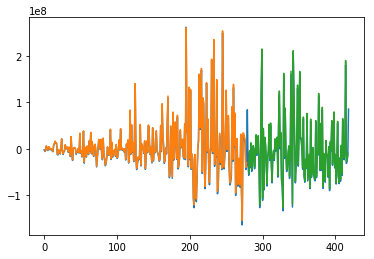

testPredict [[ -5.34322360e+07]
 [ -4.38338750e+06]
 [ -3.72141280e+07]
 [  1.26970680e+07]
 [ -4.51952560e+07]
 [ -3.52261000e+07]
 [  6.54569050e+06]
 [ -9.47312683e+02]
 [ -3.92003720e+07]
 [ -1.07835240e+07]
 [  3.00458320e+07]
 [ -1.09128170e+07]
 [ -8.66144400e+06]
 [  2.80692480e+07]
 [ -1.84956040e+07]
 [ -1.20583328e+08]
 [ -8.51099440e+07]
 [  1.18981456e+08]
 [  2.15378928e+08]
 [ -1.06756304e+08]
 [  4.38204360e+07]
 [ -8.52049600e+07]
 [  2.45692800e+07]
 [  1.10783490e+07]
 [ -2.45780720e+07]
 [ -7.63315200e+07]
 [ -1.74518680e+07]
 [ -1.65576362e+06]
 [  5.28048400e+07]
 [ -2.19877720e+07]
 [  5.54346600e+07]
 [ -3.15501260e+07]
 [ -6.96874880e+07]
 [ -1.24862620e+07]
 [ -3.79524375e+06]
 [ -2.09214680e+07]
 [  2.12858800e+07]
 [ -4.71915469e+05]
 [  4.58562700e+06]
 [  2.50075860e+07]
 [ -5.73227200e+07]
 [  5.91336720e+07]
 [  1.24502640e+08]
 [  3.64511625e+06]
 [  3.49611120e+07]
 [ -6.49692240e+07]
 [ -8.03450960e+07]
 [ -1.27942328e+08]
 [  1.62732128e+08]
 [ -1.67

D:\Software\Anaconda2\envs\conda36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tBalance
yBalance
total_purchase_amt
direct_purchase_amt
purchase_bal_amt
purchase_bank_amt
total_redeem_amt
consume_amt
transfer_amt
tftobal_amt
tftocard_amt
share_amt


In [17]:
# 残差LSTM

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import keras.models
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

import pandas as pd
from sklearn.externals import joblib
import os

# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
# convert an array of values into a dataset matrix
def create_dataset(dataset_X, dataset_Y, look_back=1):
    dataX, dataY = [], []
    dataX = dataset_X[0:len(dataset_Y)-look_back-1]
    for i in range(len(dataset_Y)-look_back-1):
        dataY.append(dataset_Y[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# # load the dataset
# dataframe = read_csv('./file/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# plt.plot(dataset)
# plt.show()

df = pd.read_csv('../file/hybrid_total_redeem.csv', index_col='report_date')
labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    df[label] = pd.to_numeric(df[label], errors='coerce')

dataframe = df['total_redeem_amt']
dataset = dataframe.values
dataset = dataset.astype('float64')
plt.plot(dataset)
plt.show()

dataframe_mulfeature = df[1:]
dataset_mulfeature = dataframe_mulfeature.values
dataset_mulfeature = dataset_mulfeature.astype('float64')

# fix random seed for reproducibility
numpy.random.seed(7)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = dataset.reshape(-1,1)
print(dataset)

dataset = scaler.fit_transform(dataset)
scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset_mulfeature = scaler2.fit_transform(dataset_mulfeature)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_x, test_x = dataset_mulfeature[0:train_size,:], dataset_mulfeature[train_size:len(dataset),:]
train_y,test_y = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train_x,train_y, look_back)
testX, testY = create_dataset(test_x,test_y, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX",trainX.shape)
print("trainY",trainY.shape)
print("testX",testX.shape)
print("testY",testY.shape)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(1, 12)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
myfile = os.path.exists("lstm.model")
if myfile:
    print("ssss")
else:
    model_prob = model.fit(trainX, trainY, epochs=105, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print('testPredict', testPredict, 'len', len(testPredict))

df = pd.read_csv('../file/user_balance_table_all.csv', index_col='user_id', names=['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3', 'category4'
], parse_dates=[1])

df['report_date'] = pd.to_datetime(df['report_date'], errors='coerce')

labels = ['tBalance', 'yBalance', 'total_purchase_amt', 'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt', 'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']
for label in labels:
    print(label)
    df[label] = pd.to_numeric(df[label], errors='coerce')

df = df.groupby('report_date').sum()
total_redeem_original = df['total_redeem_amt']

len_testPrediction = len(testPredict)
testPredict = testPredict.T
arima_redeem_prediction = total_redeem_prediction[-len_testPrediction:]

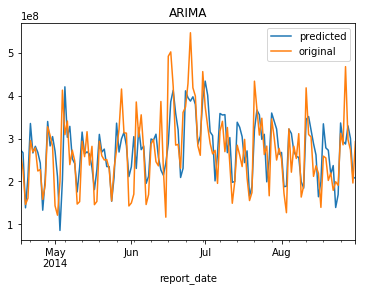

In [18]:
hybrid_redeem_prediction_val = arima_redeem_prediction.values + testPredict

sub_redeem_original = total_redeem_original[-len_testPrediction:]

arima_redeem_prediction.plot(label='predicted')
sub_redeem_original.plot(label='original')
plt.legend(loc='best')
plt.title('ARIMA')
plt.show()


In [19]:

arima_rmse = mape(arima_redeem_prediction.values, sub_redeem_original.values)
print('ARIMA RMSE', arima_rmse)

sub_redeem_original_val = sub_redeem_original.values
hybrid_rmse = mape(hybrid_redeem_prediction_val[0], sub_redeem_original_val)

print('Hybrid RMSE', hybrid_rmse)

# hybrid_redeem_prediction_val
print(len(sub_redeem_original_val))
print(len(hybrid_redeem_prediction_val[0]))

# sub_redeem_original_val.plot(label = 'original')
# hybrid_redeem_prediction_val.plot(label = 'predicted')
# plt.legend(loc='best')
# plt.title('Hybrid')
# plt.show()


ARIMA RMSE 0.272953513976
Hybrid RMSE 26.6715023926
137
137
